In [22]:
from gluefactory.utils.experiments import load_experiment
from torchvision.transforms import Resize
from gluefactory.models.lines.deeplsd import DeepLSD
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import flow_vis

In [6]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [7]:
model_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "max_num_keypoints": 1000,  # setting for training, for eval: -1
    "pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}

jpldd_model = load_experiment("training_checkpoint.tar",model_conf)

[05/10/2024 16:16:26 gluefactory.utils.experiments INFO] Loading checkpoint training_checkpoint.tar
Load pretrained weights for aliked parts...


In [23]:
conf_lines = {
    "min_length": 15,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": False,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}
size = (800,800)


deeplsd_model = DeepLSD(conf_lines)
deeplsd_model.eval()
resize_func = Resize(size)
image_path = "../data/mini_depth_100/00080.jpg"
img = cv2.resize(cv2.imread(image_path),size)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)
with torch.no_grad():
    output_jpldd = jpldd_model({"image": img_torch})
    output_deeplsd = deeplsd_model.forward_ha({"image": img_torch})
distance_field_jpldd = output_jpldd["deeplsd_line_distancefield"][0]
angle_field_jpldd = output_jpldd["deeplsd_line_anglefield"][0]
distance_field_deeplsd = output_deeplsd["df"][0]
angle_field_deeplsd = output_deeplsd["line_level"][0]


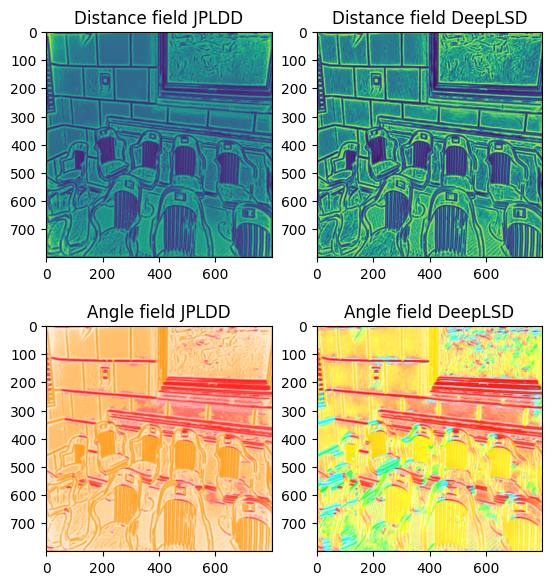

In [34]:
f, axarr = plt.subplots(2,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow(distance_field_jpldd)
axarr[0][0].set_title("Distance field JPLDD")
axarr[1][0].imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))
axarr[1][0].set_title("Angle field JPLDD")
axarr[0][1].imshow(distance_field_deeplsd)
axarr[0][1].set_title("Distance field DeepLSD")
axarr[1][1].imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
axarr[1][1].set_title("Angle field DeepLSD")
f.set_figheight(7)

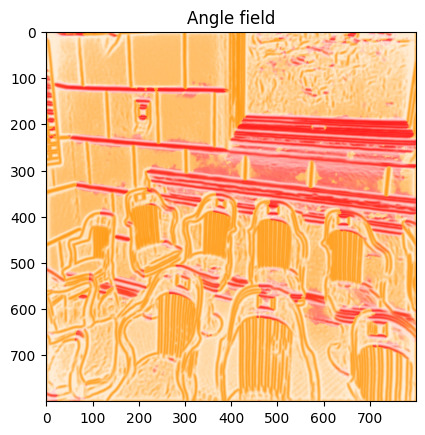

In [17]:
plt.title("Angle field")

plt.imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))